In [19]:
import astropy.io.fits as fits
import des_functions
import treecorr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
import pyccl as ccl
from more_itertools import locate
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
data_dir = '/home/b7009348/projects/WGL_Project/DES-data/'

# Calculating F 

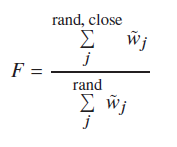

In [2]:
Image.open('F_equation.png')

- Difference in comoving distance, not redshift: 100Mpc/h
- Don't do it on a per galaxy basis (too computationally intense)
- Make finely binned histogram of lenses & source in Z
- Calculate comoving distance for each slice
- Include weights in histogram

### Loading and cutting data

In [3]:
# load in redmagic photo-z values for all lenses
with fits.open(data_dir+'DES_Y1A1_3x2pt_redMaGiC_RANDOMS.fits') as hdu:
    data = hdu[1].data
    lens_z = data['z']
del data

In [4]:
# load in source IDs for matched im3shape catalogue
with fits.open(data_dir+'y1_im3_shapes_matched.fits') as hdu:
    data = hdu[1].data
    im3_ID = data['coadd_objects_id']
    im3_weight = data['weight']
del data

In [5]:
# load in z_mc for all sources
with fits.open(data_dir+'y1a1-gold-mof-badregion_BPZ.fits') as hdu:
    data = hdu[1].data
    im3_zmc = data['Z_MC']
    zmc_ID = data['COADD_OBJECTS_ID']
del data

In [6]:
# match z_mc values to source IDs
matches, zmc_indices, shape_indices = np.intersect1d(zmc_ID, im3_ID, return_indices=True)

print(np.size(zmc_indices), np.size(im3_ID))
print(zmc_indices)

17865244 17865244
[        4        36        40 ... 134678888 134678905 134678967]


In [7]:
# slice z_mc values to only to those in matched catalogue
im3_zmc = im3_zmc[zmc_indices]

# delete uneccessary arrays
del matches, zmc_indices, shape_indices, zmc_ID

### Creating histogram data for lenses & sources

In [8]:
# set number of bins and code will bin date in range max-min zmc, incl. weights
nbins = 100

source_freq, source_bin_edges = np.histogram(im3_zmc, bins=nbins, range=(im3_zmc.min(), im3_zmc.max()), weights=im3_weight)

lens_freq, lens_bin_edges = np.histogram(lens_z, bins=nbins, range=(lens_z.min(), lens_z.max()))

In [9]:
# calculate bin width and find bin centers
source_binsz = np.mean(np.diff(source_bin_edges))
source_bin_centers = source_bin_edges[1:] - source_binsz/2.0

lens_binsz = np.mean(np.diff(lens_bin_edges))
lens_bin_centers = lens_bin_edges[1:] - lens_binsz/2.0

### Convert to comoving distance

In [10]:
# Set up cosmological parameters

OmegaM = 0.293
OmegaB = 0.0475
n_s = 1.0
sigma8 = 0.966
Ho = 70.8
h = Ho/100.0 # h = H0/100

# Set up a cosmology object, we need this to do calculations

cosmo = ccl.Cosmology(Omega_c = OmegaM-OmegaB, Omega_b = OmegaB, n_s = n_s, h = h, sigma8 = sigma8)

source_chi = ccl.comoving_radial_distance(cosmo, 1.0/(1.0+source_bin_centers))
lens_chi = ccl.comoving_radial_distance(cosmo, 1.0/(1.0+lens_bin_centers))

### Find 'rand,close'
- Only lens-source bin pairs within 100Mpc/h

In [11]:
close_pairs = []
old_rand_close = 0.0
for i in range(len(source_chi)):
    for j in range(len(lens_chi)):
        if abs(source_chi[i] - lens_chi[j]) <= 100.0:
            close_pairs.append((i, j))
            rand_close = old_rand_close + source_freq[i] * lens_freq[j]
            old_rand_close = rand_close

all_pairs = []
old_rand = 0.0
for i in range(len(source_chi)):
    for j in range(len(lens_chi)):
        all_pairs.append((i, j))
        rand = old_rand + source_freq[i] * lens_freq[j]
        old_rand = rand

In [12]:
F = rand_close/rand
print(F)

0.07405504617872546


In [13]:
print(source_freq[4])
print(lens_freq[1])

7921776.598219698
100393


# Implementing calculation of F as a function and finding convergence for nbins

In [14]:
nbins = 100
F_old = des_functions.calculate_F(nbins=nbins, source_z=im3_zmc, lens_z=lens_z,
                                      source_weights=im3_weight)
x = [100]
y = [F_old]
F_diff = 1.0
while F_diff > 1e-6:
    nbins = nbins+10
    F = des_functions.calculate_F(nbins=nbins, source_z=im3_zmc, lens_z=lens_z,
                                      source_weights=im3_weight)
    F_diff = abs(F-F_old)
    F_old = F
    x.append(nbins)
    y.append(F)

print(F, nbins)

0.07300105990520547 810


In [61]:
print(y[-1])

0.07300105990520547


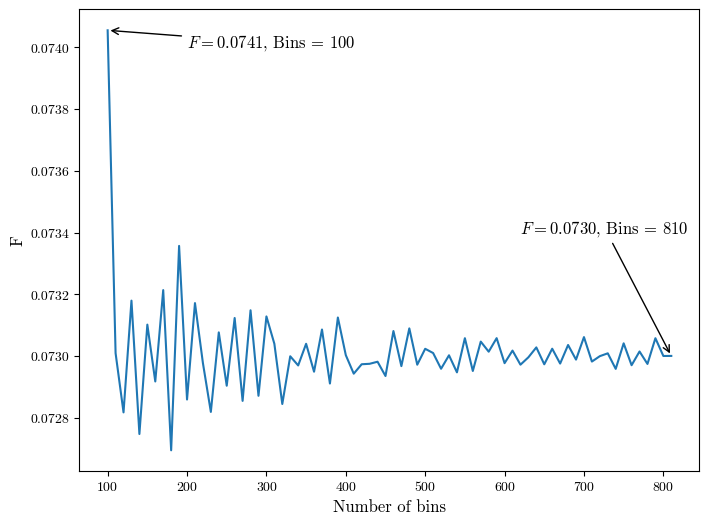

In [62]:
plt.figure(figsize=[8,6])
plt.plot(x,y)
plt.annotate(r'$F = 0.0741$, Bins = $100$', xy=[100, 0.07405504617872546], xytext=[200, 0.0740], arrowprops=dict(arrowstyle='->'), fontsize=12)
plt.annotate(r'$F = 0.0730$, Bins = $810$', xy=[810, 0.07300105990520547], xytext=[620, 0.0734], arrowprops=dict(arrowstyle='->'), fontsize=12)
plt.xlabel('Number of bins', fontsize=12)
plt.ylabel('F', fontsize=12)
plt.savefig('F_convergence.png', dpi=300)